In [1]:
import cv2 as cv2
import glob
import numpy as np
import sys
from scipy import linalg
import yaml
import os

calibration_settings = {}

In [2]:
#Given Projection matrices P1 and P2, and pixel coordinates point1 and point2, return triangulated 3D point.
def DLT(P1, P2, point1, point2):

    A = [point1[1]*P1[2,:] - P1[1,:],
         P1[0,:] - point1[0]*P1[2,:],
         point2[1]*P2[2,:] - P2[1,:],
         P2[0,:] - point2[0]*P2[2,:]
        ]
    A = np.array(A).reshape((4,4))

    B = A.transpose() @ A
    U, s, Vh = linalg.svd(B, full_matrices = False)

    #print('Triangulated point: ')
    #print(Vh[3,0:3]/Vh[3,3])
    return Vh[3,0:3]/Vh[3,3]

In [3]:
#Open and load the calibration_settings.yaml file
def parse_calibration_settings_file(filename):
    
    global calibration_settings

    if not os.path.exists(filename):
        print('File does not exist:', filename)
        quit()
    
    print('Using for calibration settings: ', filename)

    with open(filename) as f:
        calibration_settings = yaml.safe_load(f)

    #rudimentray check to make sure correct file was loaded
    if 'camera0' not in calibration_settings.keys():
        print('camera0 key was not found in the settings file. Check if correct calibration_settings.yaml file was passed')
        quit()


In [4]:
parse_calibration_settings_file("calibration_settings.yaml")

Using for calibration settings:  calibration_settings.yaml


In [5]:
def calibrate_camera(images_path): 
    # Defining the dimensions of checkerboard
    CHECKERBOARD = (4,6)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
 
    # Creating vector to store vectors of 3D points for each checkerboard image
    objpoints = []
    # Creating vector to store vectors of 2D points for each checkerboard image
    imgpoints = [] 
    objp = np.zeros((1, CHECKERBOARD[0] * CHECKERBOARD[1], 3), np.float32)
    objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
    prev_img_shape = None

    # Extracting path of individual image stored in a given directory
    images = glob.glob(images_path)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK + cv2.CALIB_CB_NORMALIZE_IMAGE)
        if ret == True:
            objpoints.append(objp)
            # refining pixel coordinates for given 2d points.
            corners2 = cv2.cornerSubPix(gray, corners, (10,10),(-1,-1), criteria)

            imgpoints.append(corners2)
            #img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2, ret)
    
        #cv2.imshow('img',img)
        #cv2.waitKey(0)

    cv2.destroyAllWindows()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

In [6]:
LA_mono_calibration_images = "/Users/hagedorn/Desktop/calibration/LA/*"
RA_mono_calibration_images = "/Users/hagedorn/Desktop/calibration/RA/*"

In [7]:
LA_ret, LA_mtx, LA_dist, LA_R, LA_T = calibrate_camera(LA_mono_calibration_images) 
print(LA_ret)

0.30637449564469593


In [8]:
RA_ret, RA_mtx, RA_dist, RA_R, RA_T = calibrate_camera(RA_mono_calibration_images) 
print(RA_ret)

0.2687664892486777


In [9]:
def save_camera_intrinsics(camera_matrix, distortion_coefs, camera_name):

    #create folder if it does not exist
    if not os.path.exists('camera_parameters'):
        os.mkdir('camera_parameters')

    out_filename = os.path.join('camera_parameters', camera_name + '_intrinsics.dat')
    outf = open(out_filename, 'w')

    outf.write('intrinsic:\n')
    for l in camera_matrix:
        for en in l:
            outf.write(str(en) + ' ')
        outf.write('\n')

    outf.write('distortion:\n')
    for en in distortion_coefs[0]:
        outf.write(str(en) + ' ')
    outf.write('\n')

In [10]:
save_camera_intrinsics(LA_mtx, LA_dist, 'LA') 

In [11]:
save_camera_intrinsics(RA_mtx, RA_dist, 'RA') 

In [12]:
import os
import cv2

# Directory containing the images
directory = "/Users/hagedorn/Desktop/calibration/synched/synched-LA"

# Define the desired resolution
new_resolution = (1920, 1080)

# Iterate through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Ensure it's an image file
        filepath = os.path.join(directory, filename)
        img = cv2.imread(filepath)
        if img is not None:  # Check if the image is read successfully
            # Get the size of the current image
            size = img.shape[:2]  # Extract width and height
            print(f"Image {filename} size/shape: {size}")
            
            # Check if image shape matches desired resolution
            if size != new_resolution:
                # Resize the image
                resized_image = cv2.resize(img, new_resolution)
                
                # Save the resized image with the original name
                cv2.imwrite(filepath, resized_image)
                print(f"Resized {filename} to {new_resolution}")
            else:
                print(f"Image {filename} already has desired resolution")
        else:
            print(f"Failed to read image {filename}")


Image 5_LA_233.jpg size/shape: (1080, 1920)
Resized 5_LA_233.jpg to (1920, 1080)
Image 2_LA_227.8.jpg size/shape: (1080, 1920)
Resized 2_LA_227.8.jpg to (1920, 1080)
Image 4_LA_228.jpg size/shape: (1080, 1920)
Resized 4_LA_228.jpg to (1920, 1080)
Image 6_LA_227.9.jpg size/shape: (1080, 1920)
Resized 6_LA_227.9.jpg to (1920, 1080)
Image 3_LA_232.9.jpg size/shape: (1080, 1920)
Resized 3_LA_232.9.jpg to (1920, 1080)
Image 1_LA_calib_81.4.jpg size/shape: (1080, 1920)
Resized 1_LA_calib_81.4.jpg to (1920, 1080)


In [36]:
import os

#open paired calibration frames and stereo calibrate for cam0 to cam1 coorindate transformations
def stereo_calibrate(mtx0, dist0, mtx1, dist1, IMAGES_LA, IMAGES_RA, output_dir):
    
    CHECKERBOARD = (4, 6)
    #read the synched frames
    c0_images_names = sorted(glob.glob(IMAGES_LA))
    c1_images_names = sorted(glob.glob(IMAGES_RA))

    #open images
    c0_images = [cv2.imread(imname, 1) for imname in c0_images_names]
    c1_images = [cv2.imread(imname, 1) for imname in c1_images_names]
    print(c0_images_names)
    print(c1_images_names)
    #change this if stereo calibration not good.
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    #calibration pattern settings
    rows = CHECKERBOARD[0]
    columns = CHECKERBOARD[1]
    world_scaling = 5.5

    #coordinates of squares in the checkerboard world space
    objp = np.zeros((rows*columns, 3), np.float32)
    objp[:, :2] = np.mgrid[0:rows, 0:columns].T.reshape(-1, 2)
    objp = world_scaling * objp

    #frame dimensions. Frames should be the same size.
    width = c0_images[0].shape[1]
    height = c0_images[0].shape[0]

    #Pixel coordinates of checkerboards
    imgpoints_left = [] # 2d points in image plane.
    imgpoints_right = []

    objpoints = [] # 3d point in real world space
    conv_size = (10, 10)

    for i, (frame0, frame1) in enumerate(zip(c0_images, c1_images)):
        
        gray1 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        c_ret1, corners1 = cv2.findChessboardCorners(gray1, CHECKERBOARD)
        c_ret2, corners2 = cv2.findChessboardCorners(gray2, CHECKERBOARD)

        if c_ret1 == True and c_ret2 == True:

            corners1 = cv2.cornerSubPix(gray1, corners1, conv_size, (-1, -1), criteria)
            corners2 = cv2.cornerSubPix(gray2, corners2, conv_size, (-1, -1), criteria)

            p0_c1 = corners1[0,0].astype(np.int32)
            p0_c2 = corners2[0,0].astype(np.int32)
            
            objpoints.append(objp)
            imgpoints_left.append(corners1)
            imgpoints_right.append(corners2)

            # Draw checkerboard corners on the images
            labeled_image0 = cv2.drawChessboardCorners(frame0.copy(), CHECKERBOARD, corners1, c_ret1)
            labeled_image1 = cv2.drawChessboardCorners(frame1.copy(), CHECKERBOARD, corners2, c_ret2)

            # Save the labeled images
            output_path0 = os.path.join(output_dir, f'labeled_{os.path.basename(c0_images_names[i])}')
            output_path1 = os.path.join(output_dir, f'labeled_{os.path.basename(c1_images_names[i])}')
            cv2.imwrite(output_path0, labeled_image0)
            cv2.imwrite(output_path1, labeled_image1)

    stereocalibration_flags = cv2.CALIB_FIX_INTRINSIC
    ret, CM1, dist0, CM2, dist1, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, mtx0, dist0,
                                                                 mtx1, dist1, (width, height), criteria=criteria, flags=stereocalibration_flags)

    print('rmse: ', ret)
    cv2.destroyAllWindows()
    return R, T


In [37]:
R, T = stereo_calibrate(LA_mtx, LA_dist, RA_mtx, RA_dist, '/Users/hagedorn/Desktop/calibration/synched/synched-LA/*','/Users/hagedorn/Desktop/calibration/synched/synched-RA/*', '/Users/hagedorn/Desktop/calibration/synched/labeled_images')

['/Users/hagedorn/Desktop/calibration/synched/synched-LA/1_LA_calib_81.4.jpg', '/Users/hagedorn/Desktop/calibration/synched/synched-LA/2_LA_227.8.jpg', '/Users/hagedorn/Desktop/calibration/synched/synched-LA/3_LA_232.9.jpg', '/Users/hagedorn/Desktop/calibration/synched/synched-LA/4_LA_228.jpg', '/Users/hagedorn/Desktop/calibration/synched/synched-LA/5_LA_233.jpg', '/Users/hagedorn/Desktop/calibration/synched/synched-LA/6_LA_227.9.jpg']
['/Users/hagedorn/Desktop/calibration/synched/synched-RA/1_RA_81.4.jpg', '/Users/hagedorn/Desktop/calibration/synched/synched-RA/2_RA_227.8.jpg', '/Users/hagedorn/Desktop/calibration/synched/synched-RA/3_RA_232.9.jpg', '/Users/hagedorn/Desktop/calibration/synched/synched-RA/4_RA_228.jpg', '/Users/hagedorn/Desktop/calibration/synched/synched-RA/5_RA_233.jpg', '/Users/hagedorn/Desktop/calibration/synched/synched-RA/6_RA_227.9.jpg']
rmse:  17.409495718371932


In [38]:
print(R,T)

[[ 0.5480143  -0.78267899  0.2951168 ]
 [ 0.25864016 -0.17697116 -0.94962439]
 [ 0.79547822  0.5967368   0.10544949]] [[-35.08936728]
 [398.57620275]
 [419.01126018]]


In [46]:


# Open paired calibration frames and stereo calibrate for cam0 to cam1 coordinate transformations
def stereo_calibrate(mtx0, dist0, mtx1, dist1, IMAGES_LA, IMAGES_RA, output_dir):
    
    CHECKERBOARD = (4, 6)
    # Read the synched frames
    c0_images_names = sorted(glob.glob(IMAGES_LA))
    c1_images_names = sorted(glob.glob(IMAGES_RA))

    # Calibration pattern settings
    rows = CHECKERBOARD[0]
    columns = CHECKERBOARD[1]
    world_scaling = 5.5

    # Coordinates of squares in the checkerboard world space
    objp = np.zeros((rows*columns, 3), np.float32)
    objp[:, :2] = np.mgrid[0:rows, 0:columns].T.reshape(-1, 2)
    objp = world_scaling * objp

    # Frame dimensions. Frames should be the same size.
    width = mtx0.shape[1]
    height = mtx0.shape[0]

    # Pixel coordinates of checkerboards
    imgpoints_left = [] # 2d points in image plane.
    imgpoints_right = []

    objpoints = [] # 3d point in real world space
    conv_size = (10, 10)

    for i, (image_path0, image_path1) in enumerate(zip(c0_images_names, c1_images_names)):
        
        frame0 = cv2.imread(image_path0)
        frame1 = cv2.imread(image_path1)
        
        gray0 = cv2.cvtColor(frame0, cv2.COLOR_BGR2GRAY)
        gray1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
        
        # Find checkerboard corners for both cameras
        ret0, corners0 = cv2.findChessboardCorners(gray0, CHECKERBOARD)
        ret1, corners1 = cv2.findChessboardCorners(gray1, CHECKERBOARD)
        
        if ret0 and ret1:
            if corners1[0][0][0] < corners1[1][0][0]:  # Check if first corner is on the right
                corners1 = corners1[::-1]  # Reverse corners to start from the left
            # Refine corners
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            corners0 = cv2.cornerSubPix(gray0, corners0, conv_size, (-1, -1), criteria)
            corners1 = cv2.cornerSubPix(gray1, cv2.UMat(corners1), conv_size, (-1, -1), criteria)
            
            objpoints.append(objp)
            imgpoints_left.append(corners0)
            imgpoints_right.append(corners1)

            # Save the labeled images
            labeled_image0 = cv2.drawChessboardCorners(frame0.copy(), CHECKERBOARD, corners0, True)
            labeled_image1 = cv2.drawChessboardCorners(frame1.copy(), CHECKERBOARD, corners1, True)
            output_path0 = os.path.join(output_dir, f'labeled_{os.path.basename(image_path0)}')
            output_path1 = os.path.join(output_dir, f'labeled_{os.path.basename(image_path1)}')
            cv2.imwrite(output_path0, labeled_image0)
            cv2.imwrite(output_path1, labeled_image1)

    stereocalibration_flags = cv2.CALIB_FIX_INTRINSIC
    ret, CM1, dist0, CM2, dist1, R, T, E, F = cv2.stereoCalibrate(objpoints, imgpoints_left, imgpoints_right, mtx0, dist0,
                                                                 mtx1, dist1, (width, height), criteria=criteria, flags=stereocalibration_flags)

    print('rmse: ', ret)
    cv2.destroyAllWindows()
    # Convert R and T to NumPy arrays
    R = np.asarray(R.get())
    T = np.asarray(T.get())
    return R, T


In [47]:
R, T = stereo_calibrate(LA_mtx, LA_dist, RA_mtx, RA_dist, '/Users/hagedorn/Desktop/calibration/synched/synched-LA/*','/Users/hagedorn/Desktop/calibration/synched/synched-RA/*', '/Users/hagedorn/Desktop/calibration/synched/labeled_images')

rmse:  5.225148322427465


In [48]:
print(np.array(R), np.array(T))

[[-0.41344715  0.27615374 -0.8676408 ]
 [-0.59287954  0.64156213  0.4867154 ]
 [ 0.69105376  0.71563758 -0.10152614]] [[ 297.73413241]
 [-120.46544695]
 [ 377.53355076]]


In [15]:
distance = np.linalg.norm(LA_T)

In [16]:
distance # in cm 

243.1292828671693

In [49]:
#Converts Rotation matrix R and Translation vector T into a homogeneous representation matrix
def _make_homogeneous_rep_matrix(R, t):
    P = np.zeros((4,4))
    P[:3,:3] = R
    P[:3, 3] = t.reshape(3)
    P[3,3] = 1
 
    return P
# Turn camera calibration data into projection matrix
def get_projection_matrix(cmtx, R, T):
    P = cmtx @ _make_homogeneous_rep_matrix(R, T)[:3,:]
    return P


In [18]:
def save_extrinsic_calibration_parameters(R0, T0, R1, T1, prefix = ''):
    
    #create folder if it does not exist
    if not os.path.exists('camera_parameters'):
        os.mkdir('camera_parameters')

    camera0_rot_trans_filename = os.path.join('camera_parameters', prefix + 'camera0_rot_trans.dat')
    outf = open(camera0_rot_trans_filename, 'w')

    outf.write('R:\n')
    for l in R0:
        for en in l:
            outf.write(str(en) + ' ')
        outf.write('\n')

    outf.write('T:\n')
    for l in T0:
        for en in l:
            outf.write(str(en) + ' ')
        outf.write('\n')
    outf.close()

    #R1 and T1 are just stereo calibration returned values
    camera1_rot_trans_filename = os.path.join('camera_parameters', prefix + 'camera1_rot_trans.dat')
    outf = open(camera1_rot_trans_filename, 'w')

    outf.write('R:\n')
    for l in R1:
        for en in l:
            outf.write(str(en) + ' ')
        outf.write('\n')

    outf.write('T:\n')
    for l in T1:
        for en in l:
            outf.write(str(en) + ' ')
        outf.write('\n')
    outf.close()

    return R0, T0, R1, T1

In [50]:
R0 = np.eye(3, dtype=np.float32)
T0 = np.array([0., 0., 0.]).reshape((3, 1))

#save_extrinsic_calibration_parameters(R0, T0, R, T) 

R1 = R
T1 = T

camera0_data = [LA_mtx, LA_dist, R0, T0]
camera1_data = [RA_mtx, RA_mtx, R1, T1]


In [51]:
#print(LA_R)
print(R1)

[[-0.41344715  0.27615374 -0.8676408 ]
 [-0.59287954  0.64156213  0.4867154 ]
 [ 0.69105376  0.71563758 -0.10152614]]


In [140]:

def get_world_space_origin(cmtx, dist, img_path):

    frame = cv2.imread(img_path, 1)

    #calibration pattern settings
    rows = calibration_settings['checkerboard_rows']
    columns = calibration_settings['checkerboard_columns']
    world_scaling = calibration_settings['checkerboard_box_size_scale']

    #coordinates of squares in the checkerboard world space
    objp = np.zeros((rows*columns,3), np.float32)
    objp[:,:2] = np.mgrid[0:rows,0:columns].T.reshape(-1,2)
    objp = world_scaling* objp

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (rows, columns), None)

    cv2.drawChessboardCorners(frame, (rows,columns), corners, ret)
    cv2.putText(frame, "If you don't see detected points, try with a different image", (50,50), cv2.FONT_HERSHEY_COMPLEX, 1, (0,0,255), 1)
    cv2.imwrite('world_space.jpg', frame)

    ret, rvec, tvec = cv.solvePnP(objp, corners, cmtx, dist)
    R, _  = cv.Rodrigues(rvec) #rvec is Rotation matrix in Rodrigues vector form

    return R, tvec

def get_cam1_to_world_transforms(cmtx0, dist0, R_W0, T_W0, 
                                 cmtx1, dist1, R_01, T_01,
                                 image_path0,
                                 image_path1):

    frame0 = cv2.imread(image_path0, 1)
    frame1 = cv2.imread(image_path1, 1)

    unitv_points = 5 * np.array([[0,0,0], [1,0,0], [0,1,0], [0,0,1]], dtype = 'float32').reshape((4,1,3))
    #axes colors are RGB format to indicate XYZ axes.
    colors = [(0,0,255), (0,255,0), (255,0,0)]

    #project origin points to frame 0
    points, _ = cv2.projectPoints(unitv_points, R_W0, T_W0, cmtx0, dist0)
    points = points.reshape((4,2)).astype(np.int32)
    origin = tuple(points[0])
    for col, _p in zip(colors, points[1:]):
        _p = tuple(_p.astype(np.int32))
        cv.line(frame0, origin, _p, col, 2)

    #project origin points to frame1
    R_W1 = R_01 @ R_W0
    T_W1 = R_01 @ T_W0 + T_01
    points, _ = cv2.projectPoints(unitv_points, R_W1, T_W1, cmtx1, dist1)
    points = points.reshape((4,2)).astype(np.int32)
    origin = tuple(points[0])
    for col, _p in zip(colors, points[1:]):
        _p = tuple(_p.astype(np.int32))
        cv2.line(frame1, origin, _p, col, 2)

    cv2.imwrite('frame0_to_world.jpg', frame0)
    cv2.imwrite('frame1_to_world.jpg', frame1)
    #cv2.waitKey(0)

    return R_W1, T_W1


In [52]:
LA_image_path =  "/Users/hagedorn/Desktop/calibration/synched/synched-LA/2_LA_227.8.jpg"
RA_image_path = "/Users/hagedorn/Desktop/calibration/synched/synched-RA/2_RA_227.8.jpg"

In [144]:
R_W0, T_W0 = get_world_space_origin(LA_mtx, LA_dist, LA_image_path)

In [145]:
R_W1, T_W1 = get_cam1_to_world_transforms(LA_mtx, LA_dist, R_W0, T_W0,RA_mtx,RA_dist, R1, T1, LA_image_path, RA_image_path)

In [146]:
save_extrinsic_calibration_parameters(R_W0, T_W0, R_W1, T_W1, prefix = 'world_to_')

(array([[ 0.35565297,  0.6470592 ,  0.67440741],
        [-0.9265011 ,  0.33898286,  0.16335954],
        [-0.12290926, -0.68293851,  0.72006132]]),
 array([[ -1.41827476],
        [100.20447817],
        [387.49335619]]),
 array([[ 0.89015804, -0.1976908 ,  0.41053259],
        [ 0.4299456 ,  0.6627641 , -0.61309912],
        [-0.15088221,  0.72226179,  0.67496108]]),
 array([[  3.16390129],
        [ -2.37225523],
        [403.53454717]]))

In [147]:
R_W0, T_W0 = get_world_space_origin(LA_mtx, LA_dist, LA_image_path)

R_W1, T_W1 = get_cam1_to_world_transforms(LA_mtx, LA_dist, R_W0, T_W0,
                                          RA_mtx, RA_dist, R_W1, T_W1,
                                          LA_image_path, RA_image_path)


In [22]:
import plotly.graph_objects as go
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt


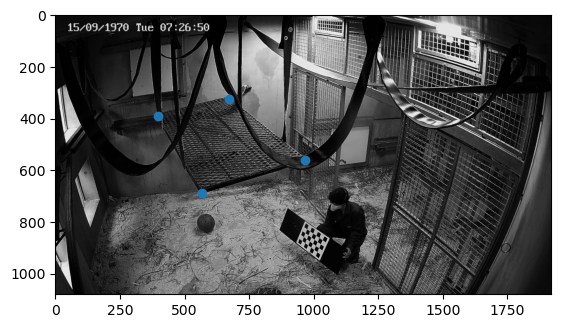

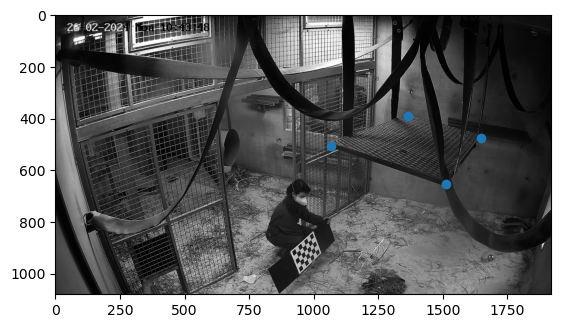

In [23]:
uvs1 = [[566.97,685.94],[395.49,390.91],[672.41,321.68],[967.44,560.26]]

uvs2 = [[1648.04,473.99],[1511.70,652.92],[1065.43,503.81],[1363.66,388.78]]

uvs1 = np.array(uvs1)
uvs2 = np.array(uvs2)
frame1 = cv2.imread(LA_image_path)
plt.imshow(frame1[:,:,[2,1,0]])
plt.scatter(uvs1[:,0], uvs1[:,1])
plt.show()

frame2 = cv2.imread(RA_image_path)
plt.imshow(frame2[:,:,[2,1,0]])
plt.scatter(uvs2[:,0], uvs2[:,1])
plt.show()

In [43]:
import cv2
import numpy as np

def triangulate_points(points1, points2, camera_matrix1, dist_coeffs1, camera_matrix2, dist_coeffs2, R1, T1, R2, T2):
    # Undistort image points
    undistorted_points1 = cv2.undistortPoints(points1, camera_matrix1, dist_coeffs1)
    undistorted_points2 = cv2.undistortPoints(points2, camera_matrix2, dist_coeffs2)

    # Convert to homogeneous coordinates
    undistorted_points1 = np.hstack((undistorted_points1, np.ones((undistorted_points1.shape[0], 1))))
    undistorted_points2 = np.hstack((undistorted_points2, np.ones((undistorted_points2.shape[0], 1))))

    # Compute projection matrices
    projection_matrix1 = get_projection_matrix(LA_mtx, LA_R, LA_T)
    projection_matrix2 = get_projection_matrix(RA_mtx, RA_R, RA_T)

    # Perform triangulation
    points_4d = cv2.triangulatePoints(projection_matrix1, projection_matrix2, undistorted_points1.T, undistorted_points2.T)
    points_3d_homogeneous = points_4d / points_4d[3]

    # Convert to 3D coordinates
    points_3d = points_3d_homogeneous[:3].T

    return points_3d

# Perform triangulation
points_3d = triangulate_points(uvs1, uvs2, LA_mtx, LA_dist, RA_mtx, RA_dist, LA_R, LA_T, RA_R, RA_T)

# Print 3D coordinates
print("Triangulated 3D points:\n", points_3d)


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 2 dimension(s)

In [53]:
P0 = get_projection_matrix(LA_mtx, R0, T0)
P1 = get_projection_matrix(RA_mtx, R1, T1)

print(P0, P1)

[[1.26078291e+03 0.00000000e+00 9.61881664e+02 0.00000000e+00]
 [0.00000000e+00 1.25918171e+03 5.58697931e+02 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]] [[ 1.05166282e+02  1.08593358e+03 -1.30331386e+03  7.83807770e+05]
 [-4.50725331e+02  1.28409068e+03  6.23480989e+02  3.74518841e+04]
 [ 6.91053762e-01  7.15637577e-01 -1.01526138e-01  3.77533551e+02]]


In [54]:


p3ds = []
for uv1, uv2 in zip(uvs1, uvs2):
    _p3d = DLT(P0, P1, uv1, uv2)
    p3ds.append(_p3d)
p3ds = np.array(p3ds)

In [55]:
def compute_distance_3d(p1, p2):
    return np.linalg.norm(p1 - p2)

In [56]:
import numpy as np

point1 = p3ds[0]
point2 = p3ds[1]
point3 = p3ds[2]
point4 = p3ds[3]

distance_between_points = compute_distance_3d(p3ds[0], p3ds[1])
print("Distance between the first two points in cm:", distance_between_points)


Distance between the first two points in cm: 111.62207199869216


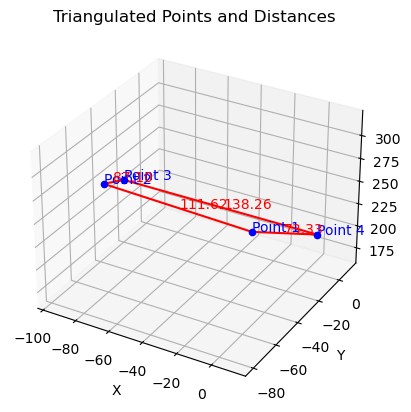

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the triangulated points
for i, point in enumerate(p3ds):
    ax.scatter(point[0], point[1], point[2], color='b')
    ax.text(point[0], point[1], point[2], f'Point {i+1}', color='b')

# Draw lines between consecutive points and display the distance
for i in range(len(p3ds)):
    start_point = p3ds[i]
    end_point = p3ds[(i + 1) % len(p3ds)]
    distance = compute_distance_3d(start_point, end_point)
    ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], [start_point[2], end_point[2]], color='r')
    mid_point = (start_point + end_point) / 2
    ax.text(mid_point[0], mid_point[1], mid_point[2], f'{distance:.2f}', color='r')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Triangulated Points and Distances')

# Show plot
plt.show()
